In [1]:
# https://drive.google.com/file/d/1YJiHQeLotsaXAXCtLLKBHPaawqKiSC5b/view?usp=drive_link
!gdown --id 1YJiHQeLotsaXAXCtLLKBHPaawqKiSC5b

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YJiHQeLotsaXAXCtLLKBHPaawqKiSC5b
To: /content/traffic_sign_detection.zip
100% 229M/229M [00:02<00:00, 90.1MB/s]


In [2]:
!unzip traffic_sign_detection.zip

Archive:  traffic_sign_detection.zip
  inflating: annotations/road0.xml   
  inflating: annotations/road1.xml   
  inflating: annotations/road10.xml  
  inflating: annotations/road100.xml  
  inflating: annotations/road101.xml  
  inflating: annotations/road102.xml  
  inflating: annotations/road103.xml  
  inflating: annotations/road104.xml  
  inflating: annotations/road105.xml  
  inflating: annotations/road106.xml  
  inflating: annotations/road107.xml  
  inflating: annotations/road108.xml  
  inflating: annotations/road109.xml  
  inflating: annotations/road11.xml  
  inflating: annotations/road110.xml  
  inflating: annotations/road111.xml  
  inflating: annotations/road112.xml  
  inflating: annotations/road113.xml  
  inflating: annotations/road114.xml  
  inflating: annotations/road115.xml  
  inflating: annotations/road116.xml  
  inflating: annotations/road117.xml  
  inflating: annotations/road118.xml  
  inflating: annotations/road119.xml  
  inflating: annotations/road12

# Import libraries

In [3]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# I. Build Traffic Sign Classification Model (SVM)

## 1. Read and extract dataset

In [4]:
annotations_dir = 'annotations'
img_dir = 'images'

img_lst = []
label_lst = []
for xml_file in os.listdir(annotations_dir):
    xml_filepath = os.path.join(annotations_dir, xml_file)
    tree = ET.parse(xml_filepath)
    root = tree.getroot()

    folder = root.find('folder').text
    img_filename = root.find('filename').text
    img_filepath = os.path.join(img_dir, img_filename)
    img = cv2.imread(img_filepath)

    for obj in root.findall('object'):
        classname = obj.find('name').text
        if classname == 'trafficlight':
            continue

        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        object_img = img[ymin:ymax, xmin:xmax]
        img_lst.append(object_img)
        label_lst.append(classname)

In [5]:
print('Number of objects: ', len(img_lst))
print('Class names: ', list(set(label_lst)))

Number of objects:  1074
Class names:  ['speedlimit', 'stop', 'crosswalk']


## 2. Preprocess images

In [6]:
def preprocess_img(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)

    resized_img = resize(
        img,
        output_shape=(32, 32),
        anti_aliasing=True
    )

    #Tạo ra vector đặc trưng
    hog_feature = feature.hog(
        resized_img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        transform_sqrt=True,
        block_norm="L2",
        feature_vector=True
    )

    return hog_feature

In [7]:
img_features_lst = []
for img in img_lst:
    hog_feature = preprocess_img(img)
    img_features_lst.append(hog_feature)

img_features = np.array(img_features_lst)

## 3. Encode label

In [8]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_lst)

## 4. Split train val set

In [9]:
random_state = 0
test_size = 0.3
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_features, encoded_labels,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

## 5. Normalization

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## 6. Training

In [11]:
clf = SVC(
    kernel='rbf',
    random_state=random_state,
    probability=True,
    C=0.5
)
clf.fit(X_train, y_train)

SVC(C=0.5, probability=True, random_state=0)

## 7. Evaluation

In [12]:
y_pred = clf.predict(X_val)
score = accuracy_score(y_pred, y_val)

print('Evaluation results on val set')
print('Accuracy: ', score)

Evaluation results on val set
Accuracy:  0.9659442724458205


# II. Traffic Sign Localization (Sliding Window)

## 1. Create sliding window function

In [13]:
def sliding_window(img, window_sizes, stride, scale_factor):
    img_height, img_width = img.shape[:2]
    windows = []
    for window_size in window_sizes:
        window_width, window_height = window_size
        for ymin in range(0, img_height - window_height + 1, stride):
            for xmin in range(0, img_width - window_width + 1, stride):
                xmax = xmin + window_width
                ymax = ymin + window_height

                windows.append([xmin, ymin, xmax, ymax])

    return windows

## 2. Create pyramid image function

In [14]:
def pyramid(img, scale=0.8, min_size=(30, 30)):
    acc_scale = 1.0
    pyramid_imgs = [(img, acc_scale)]

    i = 0
    while True:
        acc_scale = acc_scale * scale
        h = int(img.shape[0] * acc_scale)
        w = int(img.shape[1] * acc_scale)
        if h < min_size[1] or w < min_size[0]:
            break
        img = cv2.resize(img, (w, h))
        pyramid_imgs.append((img, acc_scale * (scale ** i)))
        i += 1

    return pyramid_imgs

## 3. Create bounding box visualization function

In [15]:
def visualize_bbox(img, bboxes, label_encoder):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in bboxes:
        xmin, ymin, xmax, ymax, predict_id, conf_score = box

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        classname = label_encoder.inverse_transform([predict_id])[0]
        label = f"{classname} {conf_score:.2f}"

        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

        cv2.rectangle(img, (xmin, ymin - 20), (xmin + w, ymin), (0, 255, 0), -1)

        cv2.putText(img, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 4. Create IoU computing function

In [16]:
def compute_iou(bbox, bboxes, bbox_area, bboxes_area):
    xxmin = np.maximum(bbox[0], bboxes[:, 0])
    yymin = np.maximum(bbox[1], bboxes[:, 1])
    xxmax = np.minimum(bbox[2], bboxes[:, 2])
    yymax = np.minimum(bbox[3], bboxes[:, 3])

    w = np.maximum(0, xxmax - xxmin + 1)
    h = np.maximum(0, yymax - yymin + 1)

    intersection = w * h
    iou = intersection / (bbox_area + bboxes_area - intersection)

    return iou

## 5. Create Non-Maximum Suppression function

In [17]:
def nms(bboxes, iou_threshold):
    if not bboxes:
        return []

    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1]

    xmin = np.array([bbox[0] for bbox in bboxes])
    ymin = np.array([bbox[1] for bbox in bboxes])
    xmax = np.array([bbox[2] for bbox in bboxes])
    ymax = np.array([bbox[3] for bbox in bboxes])

    areas = (xmax - xmin + 1) * (ymax - ymin + 1)

    keep = []

    while sorted_indices.size > 0:
        i = sorted_indices[0]
        keep.append(i)

        iou = compute_iou(
            [xmin[i], ymin[i], xmax[i], ymax[i]],
            np.array(
                [
                    xmin[sorted_indices[1:]],
                    ymin[sorted_indices[1:]],
                    xmax[sorted_indices[1:]],
                    ymax[sorted_indices[1:]]]
            ).T,
            areas[i],
            areas[sorted_indices[1:]]
        )

        idx_to_keep = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep + 1]

    return [bboxes[i] for i in keep]

## 6. Inference code

images/road47.png


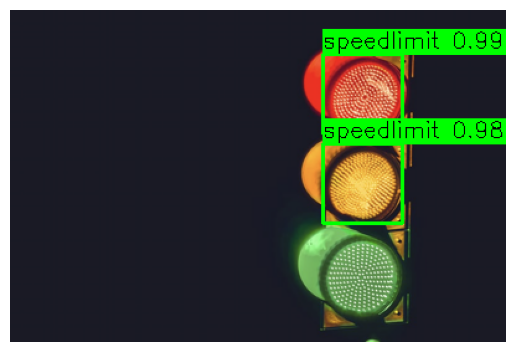

Time process:  5.485357046127319
images/road602.png


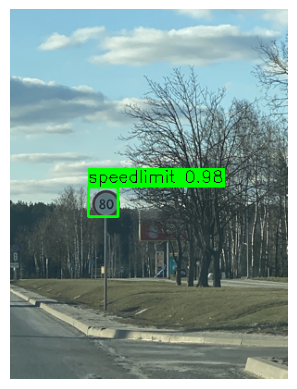

Time process:  3.9086644649505615
images/road751.png


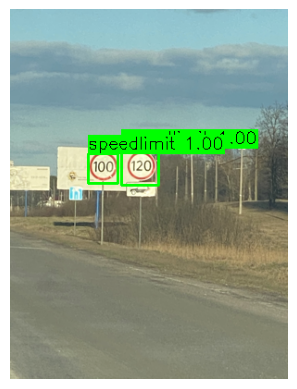

Time process:  2.581993818283081
images/road769.png


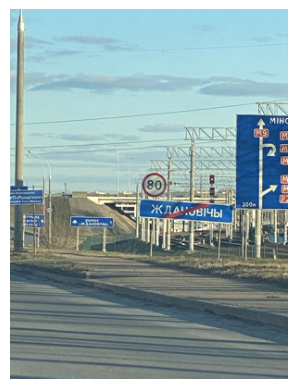

Time process:  3.0441477298736572
images/road653.png


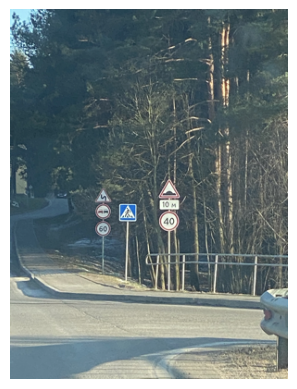

Time process:  2.5644402503967285
images/road11.png


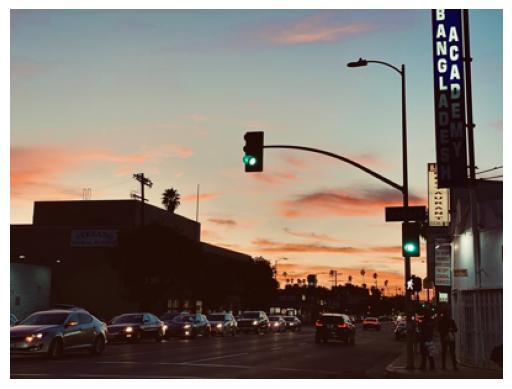

Time process:  2.573265790939331
images/road355.png


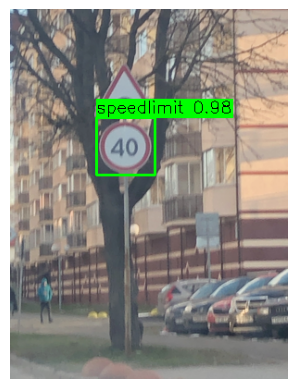

Time process:  2.5672924518585205
images/road496.png


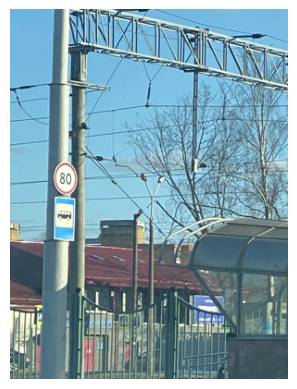

Time process:  3.093065023422241
images/road57.png


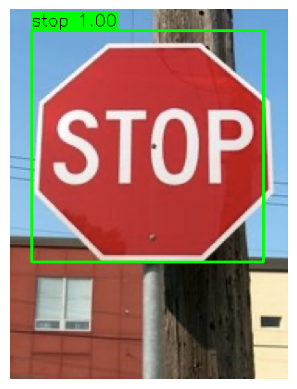

Time process:  2.5410470962524414
images/road818.png


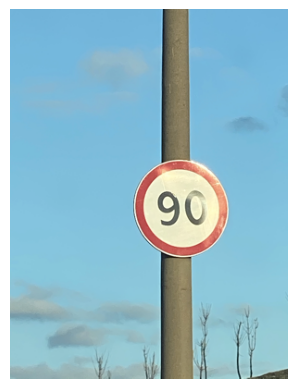

Time process:  2.478668451309204
images/road848.png


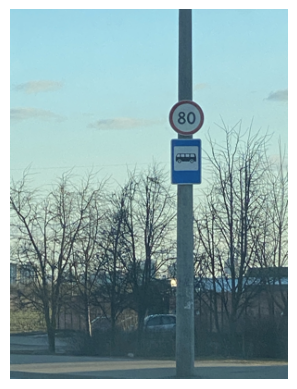

Time process:  2.5864923000335693
images/road717.png


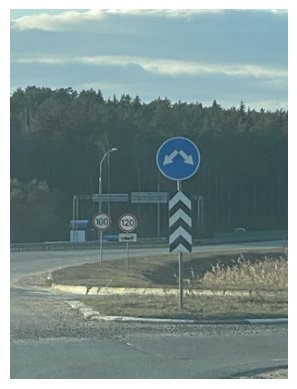

Time process:  2.7707555294036865
images/road124.png


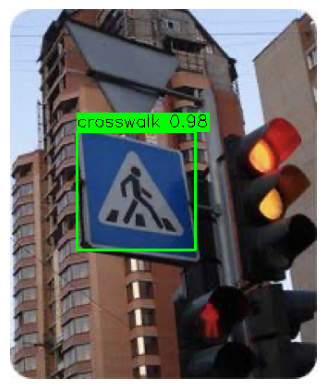

Time process:  3.2355852127075195
images/road651.png


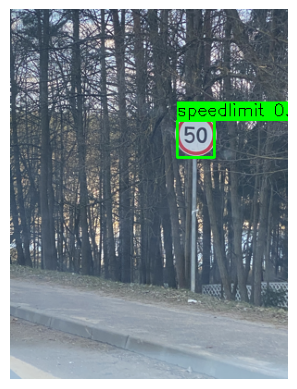

Time process:  2.573127508163452
images/road312.png


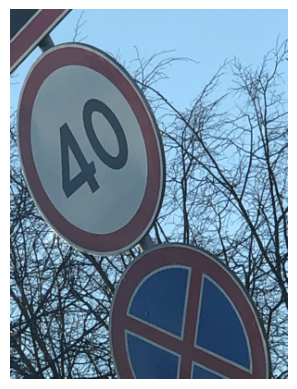

Time process:  2.567415475845337
images/road741.png


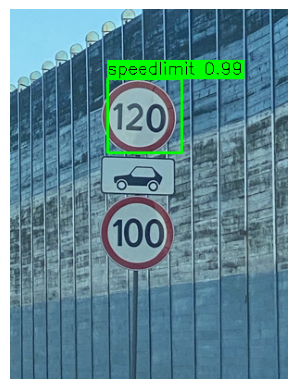

Time process:  2.5892317295074463
images/road348.png


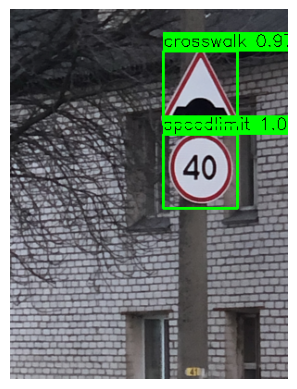

Time process:  3.0979669094085693
images/road151.png


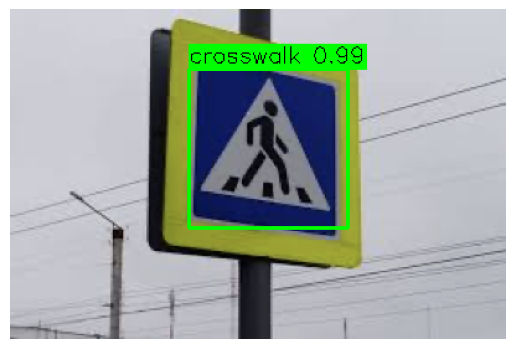

Time process:  2.1573572158813477
images/road360.png


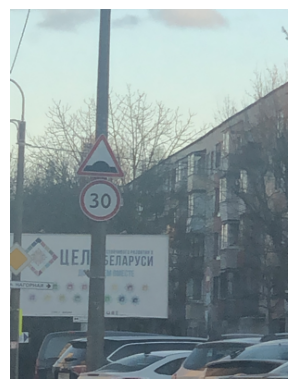

Time process:  2.562122344970703
images/road259.png


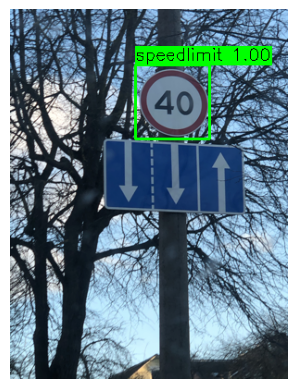

Time process:  2.6160006523132324


In [18]:
import time

img_dir = 'images'
img_filename_lst = os.listdir(img_dir)[:20]
conf_threshold = 0.95
iou_threshold = 0.1
stride = 12
window_sizes = [
    (32, 32),
    (64, 64),
    (128, 128)
]

for img_filename in img_filename_lst:
    start_time = time.time()
    img_filepath = os.path.join(img_dir, img_filename)
    print(img_filepath)
    bboxes = []
    img = cv2.imread(img_filepath)
    pyramid_imgs = pyramid(img)

    for pyramid_img_info in pyramid_imgs:
        pyramid_img, scale_factor = pyramid_img_info
        window_lst = sliding_window(
            pyramid_img,
            window_sizes=window_sizes,
            stride=stride,
            scale_factor=scale_factor
        )
        for window in window_lst:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]
            preprocessed_img = preprocess_img(object_img)
            normalized_img = scaler.transform([preprocessed_img])[0]
            decision = clf.predict_proba([normalized_img])[0]
            if np.all(decision < conf_threshold):
                continue
            else:
                predict_id = np.argmax(decision)
                conf_score = decision[predict_id]
                xmin = int(xmin / scale_factor)
                ymin = int(ymin / scale_factor)
                xmax = int(xmax / scale_factor)
                ymax = int(ymax / scale_factor)
                bboxes.append(
                    [xmin, ymin, xmax, ymax, predict_id, conf_score]
                )
    bboxes = nms(bboxes, iou_threshold)
    visualize_bbox(img, bboxes, label_encoder)

    print('Time process: ', time.time() - start_time)